In [ ]:
import numpy as np
import os

from  PIL import Image
import matplotlib.pyplot as plt
from matplotlib import image
import splitfolders

from tensorflow.python.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.layers import Conv2D, MaxPool2D, AveragePooling2D, Dropout, Flatten, Dense

from tensorflow.keras.layers import BatchNormalization
import tensorflow as tf
import keras

from tensorflow.python.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.callbacks import TensorBoard
import time



input_folder='.\\data_concreate\\D\\'
output_folder='\\data_concreate\\images\\'
InpShape=32

In [ ]:


# # Split with a ratio.
# # To only split into training and validation set, set a tuple to `ratio`, i.e, `(.8, .2)`.
# splitfolders.ratio(input_folder, output=output_folder,
#       seed=42, ratio=(.7, .2, .1), group_prefix=None, move=False) # default values



In [ ]:
METRICS = [
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      #keras.metrics.CategoricalCrossentropy(name='ccent'),
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
   
      
      #keras.metrics.AUC(name='auc'),
     # keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]



In [ ]:
inputs = tf.keras.Input(shape=(InpShape,InpShape,3))
x = tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), padding='same', strides=1, activation='relu')(inputs)
x = tf.keras.layers.MaxPool2D(pool_size=(2,2))(x)

x = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding='same', strides=1,activation='relu')(x)
x = tf.keras.layers.MaxPool2D(pool_size=(2,2))(x)
x = tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding='same', strides=1,activation='relu')(x)
x = tf.keras.layers.MaxPool2D(pool_size=(2,2))(x)
x = tf.keras.layers.Flatten()(x)

x = tf.keras.layers.Dense(16,activation='relu')(x)

x = tf.keras.layers.Dense(8,activation='relu')(x)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(inputs=inputs, outputs=outputs)







In [ ]:
model.summary()

In [ ]:

NAME="cement_binary-{}".format(int(time.time())) # log file name for tensorboard


model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.BinaryCrossentropy(), # default from_logits=False
              metrics=METRICS)



early_stop = EarlyStopping(monitor='val_loss', patience=8, verbose=1,mode='auto')
learning_rate = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, mode='auto')
tensorboard=TensorBoard(log_dir='./logs/{}'.format(NAME)) ## logs are under logs folder for tensorboard


batch_size = 32 
epochs = 75







In [47]:
import cv2
kernel_size = 5
low_threshold = 50
high_threshold = 150
rho = 1  # distance resolution in pixels of the Hough grid
theta = np.pi / 180  # angular resolution in radians of the Hough grid
threshold = 15  # minimum number of votes (intersections in Hough grid cell)
min_line_length = 6  # minimum number of pixels making up a line
max_line_gap = 5  # maximum gap in pixels between connectable line segments

def cmap_transf(img):

    #img = cv2.imread(img)
    
    blur_gray = cv2.GaussianBlur(img,(kernel_size, kernel_size),0)
          
    edges = cv2.Canny(blur_gray, low_threshold, high_threshold)
    
    line_image = np.copy(img) * 0  # creating a blank to draw lines on

    # Run Hough on edge detected image
    # Output "lines" is an array containing endpoints of detected line segments
    lines = cv2.HoughLinesP(edges, rho, theta, threshold, np.array([]),
                    min_line_length, max_line_gap)

    for line in lines:
        for x1,y1,x2,y2 in line:
                cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),5)
    
    lines_edges = cv2.addWeighted(img, 0.8, line_image, 1, 0)

    
    return lines_edges






In [48]:



train_datagen = ImageDataGenerator(rescale = 1./255.
                                  )
training_set = train_datagen.flow_from_directory('./'+output_folder + 'train',
                                                 target_size = (InpShape,InpShape),
                                                 batch_size = batch_size,
                                                 shuffle=True,
                                                 class_mode = 'binary')


Found 12442 images belonging to 2 classes.


In [ ]:
training_set.class_indices

In [49]:
val_datagen = ImageDataGenerator(rescale = 1./255.)
val_set = val_datagen.flow_from_directory('./'+output_folder +'val',
                                    
                                            target_size = (InpShape, InpShape),
                                            batch_size = batch_size,
                                            class_mode = 'binary')


Found 3554 images belonging to 2 classes.


In [ ]:
val_set.class_indices

In [50]:
history = model.fit(training_set, validation_data=val_set, 
                     epochs = epochs,callbacks = [learning_rate, early_stop, tensorboard])

error: OpenCV(4.6.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\canny.cpp:829: error: (-215:Assertion failed) _src.depth() == CV_8U in function 'cv::Canny'


In [ ]:
test_datagen = ImageDataGenerator(rescale = 1./255.)


test_set = test_datagen.flow_from_directory('./'+output_folder +'test',
                                            target_size = (InpShape, InpShape),
                                            batch_size = batch_size,
                                            class_mode = 'binary')

In [ ]:
#history.model.evaluate(test_datagen)
score = model.evaluate(test_set)

#score = model.evaluate(generator=test_set)
#print('Accuracy:', score[1])
score



In [ ]:
TP=score[4]
FP=score[5]
TN=score[6]
FN=score[7]
ACC=(TP+TN)/(TP+TN+FP+FN)
PRS=TP/(TP+FP)
REC=TP/(TP+FN)
F1=(2*PRS*REC)/(PRS+REC)
print(F1)

TN/(TN+FP)

Best model results  
56/56 [==============================] - 2s 32ms/step - loss: 0.3017 - accuracy: 0.8685 - precision: 0.8515 - recall: 0.9065 - tp: 843.0000 - fp: 147.0000 - tn: 703.0000 - fn: 87.0000
[0.3016987442970276,  
 0.8685393333435059,  
 0.8515151739120483,  
 0.9064516425132751,  
 843.0,  
 147.0,  
 703.0,  
 87.0]  

[0.3309573829174042,
 0.8668539524078369,
 0.8590673804283142,
 0.8913978338241577,
 829.0,
 136.0,
 714.0,
 101.0]

 



inputs = tf.keras.Input(shape=(InpShape,InpShape,3))  
x = tf.keras.layers.Conv2D(filters=8, kernel_size=(3,3), activation='relu')(inputs)  
x = tf.keras.layers.MaxPool2D(pool_size=(2,2))(x)  
x = tf.keras.layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu')(x)  
x = tf.keras.layers.MaxPool2D(pool_size=(2,2))(x)  
x = tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu')(x)  
x = tf.keras.layers.MaxPool2D(pool_size=(2,2))(x)  
x = tf.keras.layers.Flatten()(x)  
x = tf.keras.layers.Dropout(0.2)(x)  
x = tf.keras.layers.Dense(16,activation='relu')(x)  

x = tf.keras.layers.Dense(8,activation='relu')(x)  

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)  
model = tf.keras.Model(inputs=inputs, outputs=outputs)  

In [ ]:
model_json = model.to_json()
with open("./model/modelbm.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("./model/modelbm.h5")

### Test Model

In [ ]:
Modelmk_json = "./model/modelbm.json"
Modelmk_weigths = "./model/modelbm.h5"
from tensorflow.python.keras.models import model_from_json

def get_model(modeljson, weights):
    '''
    Function to load saved model and weights 
    '''
    model_json = open(modeljson, 'r')
    loaded_model_json = model_json.read()
    model_json.close()
    model = model_from_json(loaded_model_json)
    model.load_weights(weights)
    return model



In [ ]:
from tensorflow.keras.preprocessing import image
def model_predict(img: image, model, dima: int, dimb: int):
    '''
    Get the image data and return predictions
    '''
    img = img.resize((dima, dimb))
    x = tf.keras.preprocessing.image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = x/255
    preds = model.predict(x)

    return preds

In [ ]:

a = '021-100.jpg'
im=Image.open(a)



modelmk = get_model(Modelmk_json, Modelmk_weigths)

        # Make predictions
predsmk = model_predict(im, modelmk, InpShape, InpShape)[0][0]
#predsmk =predsmk *100
pred=predsmk *100
pred=pred.round(1)
pred


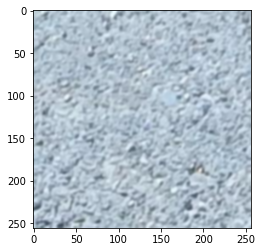

In [51]:
import cv2
img = cv2.imread('002-30.jpg')
#gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

kernel_size = 5
blur_gray = cv2.GaussianBlur(img,(kernel_size, kernel_size),0)

plt.imshow(blur_gray)



In [52]:
low_threshold = 50
high_threshold = 150
edges = cv2.Canny(blur_gray, low_threshold, high_threshold)


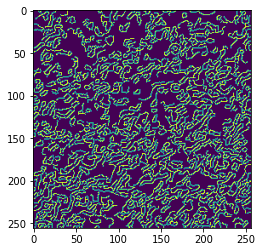

In [53]:
plt.imshow(edges)

In [54]:
rho = 1  # distance resolution in pixels of the Hough grid
theta = np.pi / 180  # angular resolution in radians of the Hough grid
threshold = 15  # minimum number of votes (intersections in Hough grid cell)
min_line_length = 6  # minimum number of pixels making up a line
max_line_gap = 5  # maximum gap in pixels between connectable line segments
line_image = np.copy(img) * 0  # creating a blank to draw lines on

# Run Hough on edge detected image
# Output "lines" is an array containing endpoints of detected line segments
lines = cv2.HoughLinesP(edges, rho, theta, threshold, np.array([]),
                    min_line_length, max_line_gap)

for line in lines:
    for x1,y1,x2,y2 in line:
        cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),5)


In [55]:
lines_edges = cv2.addWeighted(img, 0.8, line_image, 1, 0)


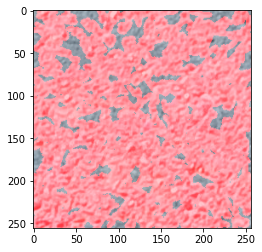

In [56]:
plt.imshow(lines_edges)

In [ ]:
_image = cv2.imread('002-80.jpg')

src_img = cv2.cvtColor(_image, cv2.COLOR_BGR2GRAY)

import cv2
img = cv2.imread('002-80.jpg')
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

kernel_size = 5
blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size),0)

plt.imshow(blur_gray)



average_color = np.average(blur_gray)
percent =0.30

max= average_color +(percent * average_color)
min= average_color -(percent * average_color)

if min < 0:
     min=0
if max > 255:
    max=255

print(min,max)
blur_gray

In [ ]:

b=blur_gray>min
b=b.astype(int)
c=blur_gray<max
c=c.astype(int)

d=b+c
d
allaverage = np.average(d)
allaverage


In [ ]:
d

In [ ]:
plt.imshow(d)